In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import make_grid
from torch.autograd import Variable
from torch import autograd

from tools.dataset import CIFAR10
from torch.utils.data import DataLoader
from tools.net import Generator, Discriminator

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
class Config:
    lr = 0.00005
    nz = 100 # noise dimension
    image_size = 64
    nc = 3 # chanel of img
    ngf = 64 # generate channel
    ndf = 64 # discriminative channel
    beta = (0.5, 0.999)
    batch_size = 32
    max_epoch = 10
    workers = 2
    gpu = True
    clamp_num = 0.01 # clipping gradient
    checkpoint_path = "./saved_model"

opt=Config()

In [4]:
transform=transforms.Compose([
    transforms.Resize(opt.image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3,[0.5]*3)
])

In [5]:
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = opt.batch_size

# construct datasets
train_set = CIFAR10(
    root=DATA_ROOT,
    mode='train',
    download=True,
    transform=transform
)
val_set = CIFAR10(
    root=DATA_ROOT,
    mode='val',
    download=True,
    transform=transform   
)

# construct dataloaders
train_loader = DataLoader(
    train_set,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=opt.workers
)

val_loader = DataLoader(
    val_set,
    batch_size=opt.batch_size,
    shuffle=True,   
    num_workers=opt.workers
)

Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified


0.00018128753 0.9994787
torch.Size([64, 64, 3])


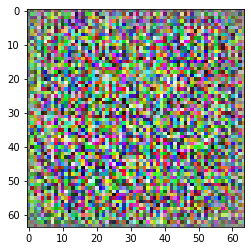

In [6]:
generator = Generator()
dummyInput = torch.randn(1,100,1,1)
testOut = generator.forward(dummyInput)
testOut = (testOut+1)/2
print(np.min(testOut.detach().numpy()), np.max(testOut.detach().numpy()))
testOut = np.squeeze(testOut.permute(2,3,1,0))
print(testOut.shape)
plt.imshow(testOut.detach().numpy())

In [7]:
discriminator = Discriminator(WGAN=True)
dtestOut = np.squeeze(discriminator.forward(generator.forward(dummyInput)))
print(dtestOut.shape, dtestOut)

torch.Size([]) tensor(1.2458, grad_fn=<SqueezeBackward0>)


In [8]:
def initialize_weights(model):
    if model.__class__.__name__.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif model.__class__.__name__.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)

In [9]:
generator.apply(initialize_weights)

Generator(
  (ct1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ac1): LeakyReLU(negative_slope=0.2, inplace=True)
  (ct2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ac2): LeakyReLU(negative_slope=0.2, inplace=True)
  (ct3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ac3): LeakyReLU(negative_slope=0.2, inplace=True)
  (ct4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ac4): LeakyReLU(negative_slope=0.2, inplace=True)
  (ct5): ConvTranspose2d(64, 3, kernel_size

In [10]:
discriminator.apply(initialize_weights)

Discriminator(
  (cv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ac1): LeakyReLU(negative_slope=0.2, inplace=True)
  (cv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ac2): LeakyReLU(negative_slope=0.2, inplace=True)
  (cv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ac3): LeakyReLU(negative_slope=0.2, inplace=True)
  (cv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ac4): LeakyReLU(negative_slope=0.2, inplace=True)
  (cv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bia

In [11]:
def calc_gradient_penalty(netD, real_images, fake_images, batch_size=opt.batch_size):
    LAMBDA = 10
    batch_size = len(real_images)
    eta = torch.FloatTensor(batch_size,1,1,1).uniform_(0,1)
    eta = eta.expand(batch_size, real_images.size(1), real_images.size(2), real_images.size(3))
    if opt.gpu:
        eta = eta.cuda()

    interpolated = eta * real_images + ((1 - eta) * fake_images)
    if opt.gpu:
        interpolated = interpolated.cuda()

    # define it to calculate gradient
    interpolated = Variable(interpolated, requires_grad=True)

    # calculate probability of interpolated examples
    prob_interpolated = netD(interpolated)

    # calculate gradients of probabilities with respect to examples
    gradients = autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(
                                   prob_interpolated.size()).cuda() if opt.gpu else torch.ones(
                                   prob_interpolated.size()),
                               create_graph=True, retain_graph=True)[0]

    # flatten the gradients to it calculates norm batchwise
    gradients = gradients.view(gradients.size(0), -1)

    grad_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return grad_penalty

In [12]:
def calc_loss_acc(generator, discriminator, real_data, noise, VERBOSE=True):
    fake_data = generator(noise)
    d_real_out = discriminator(real_data)
    d_fake_out = discriminator(fake_data)
    
    # Accuracies
    d_real_pred = (torch.sigmoid(d_real_out) >= 0.5).sum().item()
    d_fake_pred = (torch.sigmoid(d_fake_out) < 0.5).sum().item()
    d_acc = (d_real_pred + d_fake_pred) / (len(d_real_out) + len(d_fake_out))
    g_acc = (len(d_fake_out) - d_fake_pred) / len(d_fake_out)
    D_acc.append(d_acc), G_acc.append(g_acc)
    
    # Losses
    d_loss = d_fake_out.view(-1).mean() - d_real_out.view(-1).mean() + calc_gradient_penalty(discriminator, real_data, fake_data)
    g_loss = d_real_out.mean().item()
    D_losses.append(d_loss.item()), G_losses.append(g_loss)
    
    if VERBOSE:
        print("- [Test]: D loss: %.4f | G loss: %.4f | D acc: %.3f | G acc: %.3f" % (d_loss, g_loss, d_acc, g_acc))

In [13]:
optimizerD = optim.RMSprop(discriminator.parameters(),lr=opt.lr )
optimizerG = optim.RMSprop(generator.parameters(),lr=opt.lr )

test_noise = Variable(torch.FloatTensor(opt.batch_size,opt.nz,1,1).normal_(0,1))
if opt.gpu:
    test_noise = test_noise.cuda()
    discriminator.cuda()
    generator.cuda()

In [14]:
D_acc = []
G_acc = []
D_losses = []
G_losses = []

===> Training starts
Epoch 0:
[499/1407]	D Accuracy: 0.0000 | G Accuracy: 1.0000
[999/1407]	D Accuracy: 0.0000 | G Accuracy: 1.0000
- [Test]: D loss: 7.8368 | G loss: 25.1098 | D acc: 0.500 | G acc: 1.000


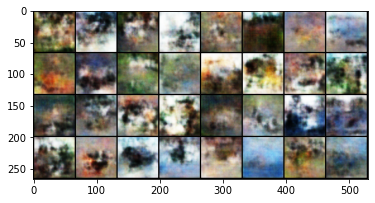

Epoch 1:


KeyboardInterrupt: 

In [21]:
one=torch.FloatTensor([1])
mone=-1*one

print("===> Training starts")
for epoch in range(opt.max_epoch):
    
    print(f"Epoch {epoch}:")
    
    for batch_idx, data in enumerate(train_loader,0):
        real, _ = data
        inputs = Variable(real)
        noise = Variable(torch.randn(inputs.size(0),opt.nz,1,1))

        if opt.gpu:
            one = one.cuda()
            mone = mone.cuda()
            noise = noise.cuda()
            inputs = inputs.cuda()

        # for parm in discriminator.parameters():
        #         parm.data.clamp_(-opt.clamp_num,opt.clamp_num)

        # ------------------------
        # - Train Discriminator  -
        # ------------------------
        discriminator.zero_grad()
        
        ## train discriminator with real img
        d_real_out = discriminator(inputs).mean().view(-1)
        d_real_out.backward(one)
        
        ## train discriminator with fake img
        g_out = generator(noise).detach()
        d_fake_out = discriminator(g_out).mean().view(-1)
        d_fake_out.backward(mone)

        ## gradient penalty
        gradient_penalty = calc_gradient_penalty(discriminator, inputs, g_out)
        gradient_penalty.backward()
        
        optimizerD.step()

        # -----------------------
        # -   Train Generator   -
        # -----------------------
        
        if (batch_idx + 1) % 5 == 0:
            generator.zero_grad()
            noise.data.normal_(0,1)
            g_out = generator(noise)
            d_real_out = discriminator(g_out).mean().view(-1)
            d_real_out.backward(one)
            optimizerG.step()
            
            # Output training stats
            if (batch_idx + 1) % 500 == 0:
                d_g_out = discriminator(g_out)
                fake_pred = ((torch.sigmoid(d_g_out.view(-1)) < 0.5)).sum().item()
                d_acc = fake_pred / len(d_g_out)
                g_acc = (len(d_g_out) - fake_pred) / len(d_g_out)
                print('[%d/%d]\tD Accuracy: %.4f | G Accuracy: %.4f' % (batch_idx, len(train_loader), d_acc, g_acc))

    
    # Calculate losses, accuracies, and display generator's output
    calc_loss_acc(generator, discriminator, next(iter(val_loader))[0].cuda(), test_noise)
    test_g_out = generator(test_noise)
    test_imgs = make_grid(test_g_out.data*0.5+0.5).cpu()
    plt.imshow(test_imgs.permute(1,2,0).numpy()) 
    plt.show()
    
    # Save model
    if epoch % 5 == 0 and epoch != 0:
        if not os.path.exists(opt.checkpoint_path):
            os.makedirs(opt.checkpoint_path)
        print("Saving ...")
        stateG = {'state_dict': generator.state_dict(),
                'epoch': epoch}
        stateD = {'state_dict': discriminator.state_dict(),
                'epoch': epoch}
        torch.save(stateG, opt.checkpoint_path + "/WGAN_generator.pth")
        torch.save(stateD, opt.checkpoint_path + "/WGAN_discriminator.pth")

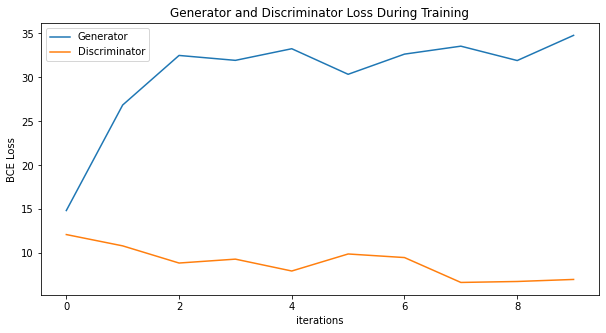

In [21]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("BCE Loss")
plt.legend()
plt.show()

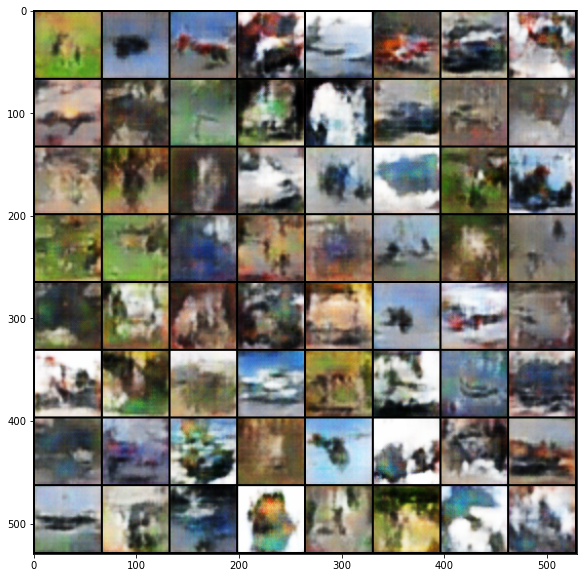

In [15]:
noise = torch.randn(64,opt.nz,1,1).cuda()
noise = Variable(noise)
fake_u=netg(noise)
imgs = make_grid(fake_u.data*0.5+0.5).cpu()
plt.figure(figsize=(10,10))
plt.imshow(imgs.permute(1,2,0).numpy())
plt.show()